In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import np_utils
import pywt
import keras
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
penghuni = os.listdir("C:\\Users\\muham\\OneDrive\\Documents\\TA\\images\\train\\Penghuni")
temen1 = os.listdir("C:\\Users\\muham\\OneDrive\\Documents\\TA\\images\\train\\Temen1")
bkn_penghuni = os.listdir("C:\\Users\\muham\\OneDrive\\Documents\\TA\\images\\train\\BukanPenghuni")

In [3]:
totalaccuracy = []
totalprecision = []
totalrecall = []
totalf1 = []

In [4]:
def CNNbuild(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels,)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [5]:
def CalcFeatures(img, th):
    sift = cv2.xfeatures2d.SIFT_create(th)
    kp, des = sift.detectAndCompute(img, None)
    return des

In [6]:
def bag_of_features(features, centres, k = 500):
    vec = np.zeros((1, k))
    for i in range(features.shape[0]):
        feat = features[i]
        diff = np.tile(feat, (k, 1)) - centres
        dist = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
        idx_dist = dist.argsort()
        idx = idx_dist[0]
        vec[0][idx] += 1
    return vec

In [7]:
data = []
labels = []
features = []

In [8]:
for i in penghuni:

    image = cv2.imread("C:\\Users\\muham\\OneDrive\\Documents\\TA\\images\\train\\penghuni\\"+i, 0)
    
    dim = (50, 50)
    
    resize_img = cv2.resize(image, dim)

    # Canny Edge Detection
    edges = cv2.Canny(image=resize_img, threshold1=100, threshold2=200) # Canny Edge Detection

    data.append(np.array(edges))
    labels.append(0)

#     print(len(descriptors))

for u in bkn_penghuni:
    
    image = cv2.imread("C:\\Users\\muham\\OneDrive\\Documents\\TA\\images\\train\\BukanPenghuni\\"+u, 0)
    

    dim = (50, 50)
    
    resize_img = cv2.resize(image, dim)

    edges = cv2.Canny(image=resize_img, threshold1=100, threshold2=200) # Canny Edge Detection

    data.append(np.array(edges))
    labels.append(1)

for j in temen1:
    
    image = cv2.imread("C:\\Users\\muham\\OneDrive\\Documents\\TA\\images\\train\\Temen1\\"+j, 0)
    

    dim = (50, 50)
    
    resize_img = cv2.resize(image, dim)

    edges = cv2.Canny(image=resize_img, threshold1=100, threshold2=200) # Canny Edge Detection

    data.append(np.array(edges))
    labels.append(2)

In [9]:
cells = np.array(data, dtype=object)
labels = np.array(labels)

np.save('Cells' , cells)
np.save('Labels' , labels)

n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

cells = cells.astype(np.float32)
# cells = np.reshape(cells, (274,50,50,1))
labels = labels.astype(np.int32)
cells = cells/255

In [10]:
kf =KFold(n_splits=5, shuffle=True, random_state=42)
cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(cells, labels):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    print("="*20)
    print("Fold: ", cnt)
    print("="*20)
    cnt +=1

    x_train , x , y_train , y = train_test_split(cells[train_index] , labels[train_index] , 
                                                test_size = 0.2 ,
                                                random_state = 11)

    x_eval ,x_test ,y_eval , y_test = train_test_split(x , y , 
                                                        test_size = 0.5 , 
                                                        random_state = 11)

    y_train = np_utils.to_categorical(y_train, num_classes = 3)
    y_eval = np_utils.to_categorical(y_eval, num_classes = 3)
    y_test = np_utils.to_categorical(y_test, num_classes = 3)

    #instantiate the model
    height = 50
    width = 50
    classes = 3
    channels = 1
    epoch = 75
    model = CNNbuild(height = height, width = width, classes = classes, channels = channels)
    model.summary()

    #compile the model
    model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

    #fit the model onto the dataset
    # x_train = np.array (x_train)

    h = model.fit(x_train, y_train, epochs = epoch, batch_size = 32,validation_data=(x_eval,y_eval),shuffle=True)

    #evaluate the model on test data
    predictions = model.evaluate(x_test, y_test)
    evaluation = model.evaluate(x_eval, y_eval)

    print(f'LOSS : {evaluation[0]}')
    print(f'ACCURACY : {evaluation[1]}')
    print(f'LOSS : {predictions[0]}')
    print(f'ACCURACY : {predictions[1]}')

    predict_x=model.predict(x_test) 
    yhat_classes=np.argmax(predict_x,axis=1)
    yhat_classes = np_utils.to_categorical(yhat_classes, num_classes = 3)

    # print("Precision Score : ",precision_score(y_test, y_pred, 
    #                                            pos_label='positive'
    #                                            average='micro'))
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    print('Accuracy: %f' % accuracy)
    totalaccuracy.append(accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes, average='macro')
    print('Precision: %f' % precision)
    totalprecision.append(precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes, average='macro')
    print('Recall: %f' % recall)
    totalrecall.append(recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes, average='macro')
    print('F1 score: %f' % f1)
    totalf1.append(f1)

Fold:1, Train set: 328, Test set:82
Fold:  1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 max_poolin

9/9 [==============================] - 1s 105ms/step - loss: 0.1455 - accuracy: 0.9351 - val_loss: 1.0706 - val_accuracy: 0.6667
Epoch 37/75
9/9 [==============================] - 1s 104ms/step - loss: 0.1412 - accuracy: 0.9466 - val_loss: 1.0063 - val_accuracy: 0.6667
Epoch 38/75
9/9 [==============================] - 1s 118ms/step - loss: 0.0938 - accuracy: 0.9580 - val_loss: 1.0137 - val_accuracy: 0.6667
Epoch 39/75
9/9 [==============================] - 1s 128ms/step - loss: 0.1247 - accuracy: 0.9580 - val_loss: 1.0516 - val_accuracy: 0.6667
Epoch 40/75
9/9 [==============================] - 1s 150ms/step - loss: 0.1117 - accuracy: 0.9733 - val_loss: 0.9774 - val_accuracy: 0.7576
Epoch 41/75
9/9 [==============================] - 1s 129ms/step - loss: 0.0746 - accuracy: 0.9733 - val_loss: 0.9962 - val_accuracy: 0.6970
Epoch 42/75
9/9 [==============================] - 1s 138ms/step - loss: 0.0666 - accuracy: 0.9809 - val_loss: 0.9512 - val_accuracy: 0.6970
Epoch 43/75
9/9 [========

                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_7 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 285,443
Trainable params: 284,227
Non-trainable params: 1,216
_________________________________________________________________
Epoch 1/75
9/9 [==============================] - 6s 188ms/step - 

9/9 [==============================] - 1s 97ms/step - loss: 0.0626 - accuracy: 0.9733 - val_loss: 0.4497 - val_accuracy: 0.7879
Epoch 53/75
9/9 [==============================] - 1s 100ms/step - loss: 0.0606 - accuracy: 0.9809 - val_loss: 0.4977 - val_accuracy: 0.7879
Epoch 54/75
9/9 [==============================] - 1s 98ms/step - loss: 0.1070 - accuracy: 0.9695 - val_loss: 0.5751 - val_accuracy: 0.7576
Epoch 55/75
9/9 [==============================] - 1s 96ms/step - loss: 0.0533 - accuracy: 0.9733 - val_loss: 0.6430 - val_accuracy: 0.7273
Epoch 56/75
9/9 [==============================] - 1s 111ms/step - loss: 0.0366 - accuracy: 0.9885 - val_loss: 0.7152 - val_accuracy: 0.7273
Epoch 57/75
9/9 [==============================] - 1s 100ms/step - loss: 0.0419 - accuracy: 0.9885 - val_loss: 0.7561 - val_accuracy: 0.7273
Epoch 58/75
9/9 [==============================] - 1s 90ms/step - loss: 0.0770 - accuracy: 0.9771 - val_loss: 0.6941 - val_accuracy: 0.7576
Epoch 59/75
9/9 [============

Epoch 10/75
9/9 [==============================] - 1s 96ms/step - loss: 0.4601 - accuracy: 0.8282 - val_loss: 1.1482 - val_accuracy: 0.6061
Epoch 11/75
9/9 [==============================] - 1s 98ms/step - loss: 0.3966 - accuracy: 0.8511 - val_loss: 1.3117 - val_accuracy: 0.5758
Epoch 12/75
9/9 [==============================] - 1s 97ms/step - loss: 0.3132 - accuracy: 0.9008 - val_loss: 1.4990 - val_accuracy: 0.4545
Epoch 13/75
9/9 [==============================] - 1s 154ms/step - loss: 0.3021 - accuracy: 0.8740 - val_loss: 1.5526 - val_accuracy: 0.4848
Epoch 14/75
9/9 [==============================] - 1s 160ms/step - loss: 0.3081 - accuracy: 0.8702 - val_loss: 1.4394 - val_accuracy: 0.5758
Epoch 15/75
9/9 [==============================] - 1s 127ms/step - loss: 0.2775 - accuracy: 0.8817 - val_loss: 1.3654 - val_accuracy: 0.5758
Epoch 16/75
9/9 [==============================] - 1s 115ms/step - loss: 0.2183 - accuracy: 0.9084 - val_loss: 1.4714 - val_accuracy: 0.5758
Epoch 17/75
9/9 

9/9 [==============================] - 1s 105ms/step - loss: 0.0569 - accuracy: 0.9733 - val_loss: 1.0896 - val_accuracy: 0.8182
Epoch 69/75
9/9 [==============================] - 1s 113ms/step - loss: 0.0415 - accuracy: 0.9847 - val_loss: 1.1234 - val_accuracy: 0.8182
Epoch 70/75
9/9 [==============================] - 1s 102ms/step - loss: 0.0653 - accuracy: 0.9771 - val_loss: 1.1745 - val_accuracy: 0.8182
Epoch 71/75
9/9 [==============================] - 1s 103ms/step - loss: 0.0727 - accuracy: 0.9733 - val_loss: 1.1233 - val_accuracy: 0.8182
Epoch 72/75
9/9 [==============================] - 1s 97ms/step - loss: 0.0439 - accuracy: 0.9847 - val_loss: 1.1754 - val_accuracy: 0.8182
Epoch 73/75
9/9 [==============================] - 1s 113ms/step - loss: 0.0599 - accuracy: 0.9695 - val_loss: 1.1351 - val_accuracy: 0.8182
Epoch 74/75
9/9 [==============================] - 1s 93ms/step - loss: 0.0584 - accuracy: 0.9771 - val_loss: 1.0823 - val_accuracy: 0.8182
Epoch 75/75
2/2 [==========

9/9 [==============================] - 1s 97ms/step - loss: 0.1666 - accuracy: 0.9427 - val_loss: 1.5579 - val_accuracy: 0.5758
Epoch 26/75
9/9 [==============================] - 1s 112ms/step - loss: 0.1654 - accuracy: 0.9542 - val_loss: 1.7134 - val_accuracy: 0.4848
Epoch 27/75
9/9 [==============================] - 1s 134ms/step - loss: 0.1013 - accuracy: 0.9695 - val_loss: 2.2078 - val_accuracy: 0.4242
Epoch 28/75
9/9 [==============================] - 1s 112ms/step - loss: 0.1087 - accuracy: 0.9656 - val_loss: 2.1086 - val_accuracy: 0.4545
Epoch 29/75
9/9 [==============================] - 1s 149ms/step - loss: 0.1458 - accuracy: 0.9580 - val_loss: 1.6166 - val_accuracy: 0.5455
Epoch 30/75
9/9 [==============================] - 1s 162ms/step - loss: 0.1444 - accuracy: 0.9351 - val_loss: 1.2889 - val_accuracy: 0.6061
Epoch 31/75
9/9 [==============================] - 1s 153ms/step - loss: 0.1622 - accuracy: 0.9275 - val_loss: 1.3489 - val_accuracy: 0.5758
Epoch 32/75
9/9 [=========

 batch_normalization_16 (Bat  (None, 24, 24, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 11, 11, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_17 (Bat  (None, 11, 11, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_17 (Dropout)        (None, 11, 11, 32)        0         
                                                                 
 conv2d_14

Epoch 41/75
9/9 [==============================] - 1s 119ms/step - loss: 0.0835 - accuracy: 0.9656 - val_loss: 1.9844 - val_accuracy: 0.4848
Epoch 42/75
9/9 [==============================] - 1s 155ms/step - loss: 0.0892 - accuracy: 0.9656 - val_loss: 1.7336 - val_accuracy: 0.4848
Epoch 43/75
9/9 [==============================] - 1s 100ms/step - loss: 0.1043 - accuracy: 0.9656 - val_loss: 1.2445 - val_accuracy: 0.5152
Epoch 44/75
9/9 [==============================] - 1s 105ms/step - loss: 0.1041 - accuracy: 0.9656 - val_loss: 0.9052 - val_accuracy: 0.6061
Epoch 45/75
9/9 [==============================] - 1s 90ms/step - loss: 0.1088 - accuracy: 0.9656 - val_loss: 0.9474 - val_accuracy: 0.6667
Epoch 46/75
9/9 [==============================] - 1s 90ms/step - loss: 0.0809 - accuracy: 0.9656 - val_loss: 0.9826 - val_accuracy: 0.6667
Epoch 47/75
9/9 [==============================] - 1s 85ms/step - loss: 0.1206 - accuracy: 0.9695 - val_loss: 0.8742 - val_accuracy: 0.6970
Epoch 48/75
9/9 

In [11]:
print("=" * 20)
print("rata-rata Akurasi: ",sum(totalaccuracy)/len(totalaccuracy))
print("rata-rata Presisi: ",sum(totalprecision)/len(totalprecision))
print("rata-rata Recall: ",sum(totalrecall)/len(totalrecall))
print("rata-rata F1: ",sum(totalf1)/len(totalf1))

rata-rata Akurasi:  0.8363636363636363
rata-rata Presisi:  0.858213589529379
rata-rata Recall:  0.8371840958605665
rata-rata F1:  0.8421054871054873


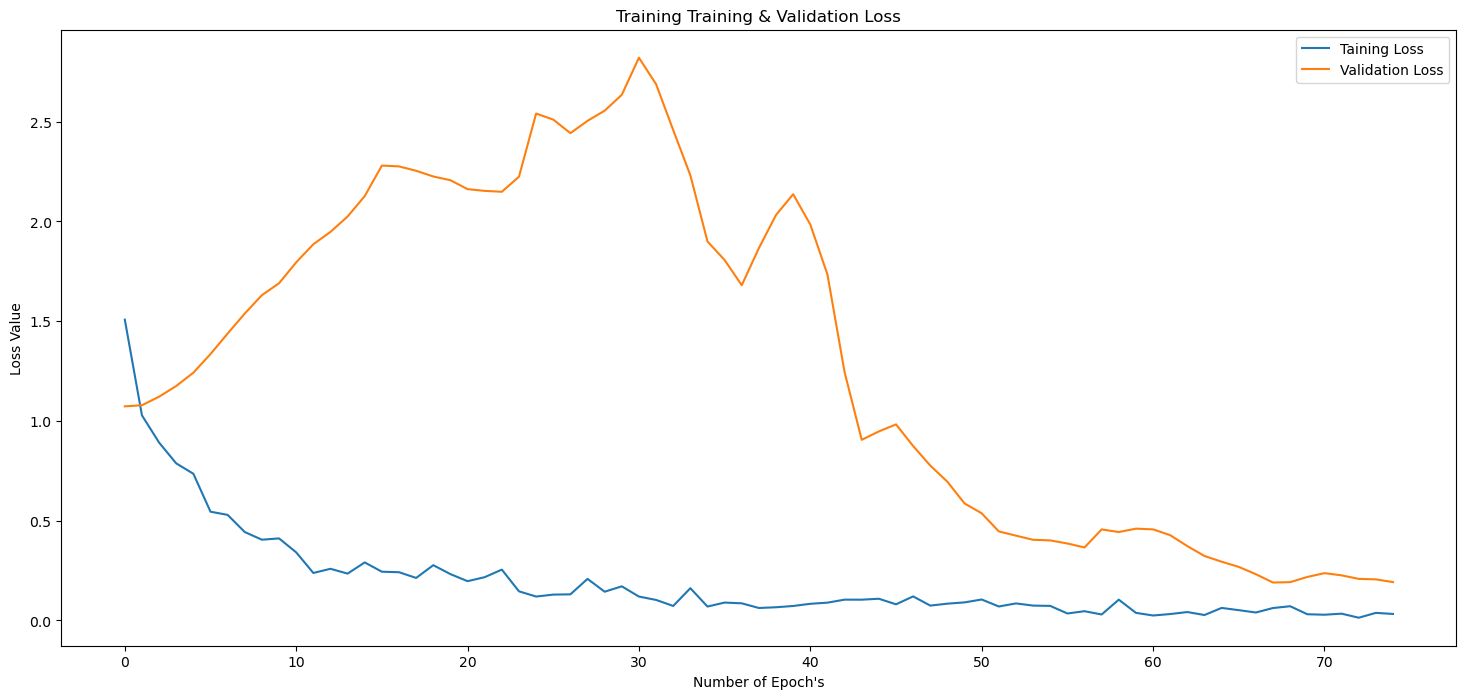

In [12]:
plt.figure(figsize = (18,8))
plt.plot(range(epoch), h.history['loss'], label = 'Taining Loss')
plt.plot(range(epoch), h.history['val_loss'], label = 'Validation Loss')
plt.xlabel("Number of Epoch's")
plt.ylabel('Loss Value')
plt.title('Training Training & Validation Loss')
plt.legend(loc = "best")

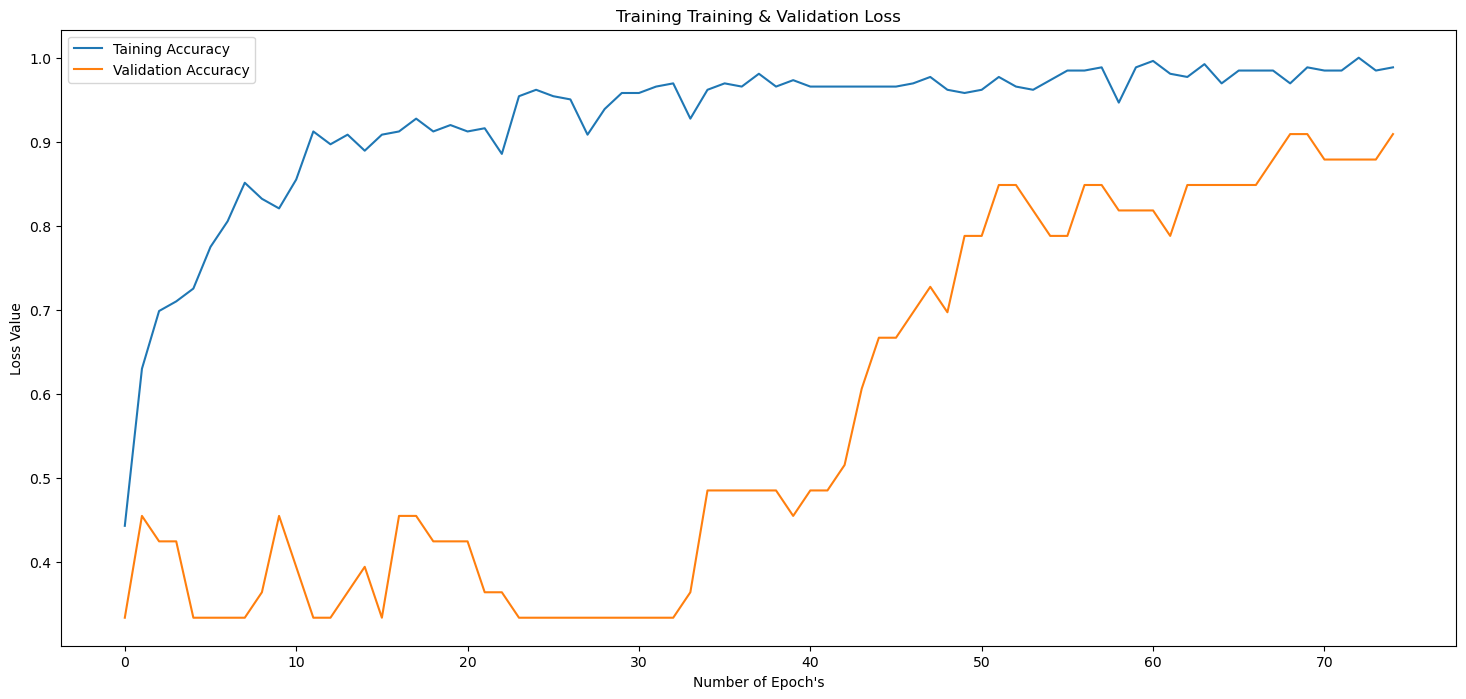

In [13]:
plt.figure(figsize = (18,8))
plt.plot(range(epoch), h.history['accuracy'], label = 'Taining Accuracy')
plt.plot(range(epoch), h.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel("Number of Epoch's")
plt.ylabel('Loss Value')
plt.title('Training Training & Validation Loss')
plt.legend(loc = "best")